In [1]:
import pandas as pd
import numpy as np
import os
import math
from sklearn.cluster import KMeans
%config IPCompleter.greedy=True

In [2]:
# Data Files
OUTPUT_DIR = 'outputs/'
INPUT_DIR = 'data/'

HOD_same = 'HumanObserved-Dataset/same_pairs.csv'
HOD_diff = 'HumanObserved-Dataset/diffn_pairs.csv'
HOD_features = 'HumanObserved-Dataset/HumanObserved-Features-Data.csv'

GSC_same = 'GSC-Dataset/same_pairs.csv'
GSC_diff = 'GSC-Dataset/same_pairs.csv'
GSC_features = 'GSC-Dataset/GSC-Features.csv'

In [3]:
# Linear Regression Variables
TrainingPercent = 80 # Data Split for Training Data
ValidationPercent = 10 # Data Split for Validation Data
TestPercent = 10 # Data Split for Testing Data


M = 10
C_Lambda = 0.03
learningRate = 0.01


In [4]:
def _remove_zero_cols(data):
    """Returns ndarray with no zero columns
    """
    data = data.transpose()
    data = data[~np.all(data == 0, axis=1)]
    data = data.transpose()
    return data


def _append_dataframes(same_data, diff_data):
    """Appends the dataframes one after another.
    """
    appended_data = pd.concat([same_data, diff_data])
    appended_data = appended_data.sample(frac=1)
    return(appended_data)


In [5]:
def _concat_dataframes(same_data, diff_data, features_data):
    """
    """
    # Combine the diff and concat data
    appended_data = _append_dataframes(same_data, diff_data)
    # Remove columns if exist
    if 'Unnamed: 0' in features_data.columns.values:
        features_data = features_data.drop(columns=['Unnamed: 0'])

    # Merge the datatables, same and diff
    merged_data = pd.merge(appended_data, features_data,
                           left_on='img_id_A', right_on='img_id', how='left')
    merged_data = pd.merge(merged_data, features_data, left_on='img_id_B',
                           right_on='img_id', how='left', suffixes=('_a', '_b'))
    merged_data = merged_data.drop(columns=['img_id_a', 'img_id_b'])
    raw_data = merged_data.loc[:, 'f1_a':].values
    raw_data = _remove_zero_cols(raw_data)
    raw_target = merged_data['target'].values
    return(raw_data, raw_target)


def _subtract_dataframes(same_data, diff_data, features_data):
    """Subtract img_id_a columns with img_id_b_columns
    """
    appended_data = _append_dataframes(same_data, diff_data)
    temp1 = pd.merge(appended_data, features_data,
                     left_on='img_id_A', right_on='img_id', how='left')
    temp2 = pd.merge(appended_data, features_data,
                     left_on='img_id_B', right_on='img_id', how='left')
    raw_data = abs(temp1.loc[:, 'f1':] - temp2.loc[:, 'f1':]).values

    raw_data = _remove_zero_cols(raw_data)
    raw_target = appended_data['target'].values

    return(raw_data, raw_target)


In [6]:
def get_data_features(category='hod', operation='concat'):
    """Returns concat/subtracted feature values
    Merge the same and diff datasets, and process the data columns
    """
    category_dict = {
        'hod': [HOD_same, HOD_diff, HOD_features],
        'gsc': [GSC_same, GSC_diff, GSC_features],
    }
    same, diff, features = category_dict[category]
    same_data = pd.read_csv(os.path.join(INPUT_DIR, same), sep=',', nrows=1000)
    diff_data = pd.read_csv(os.path.join(
        INPUT_DIR, diff),  sep=',', nrows=1000)
    features_data = pd.read_csv(os.path.join(INPUT_DIR, features), sep=',')

    if operation == 'concat':
        raw_data, raw_target = _concat_dataframes(
            same_data, diff_data, features_data)

    if operation == 'subtract':
        raw_data, raw_target = _subtract_dataframes(
            same_data, diff_data, features_data)

    return(raw_data, raw_target)


In [7]:
# data1_d, data1_t = get_data_features('hod', operation='concat')
# print(data1_d.shape, data1_t.shape)
# data1_d, data1_t = get_data_features('hod', operation='subtract')
# print(data1_d.shape, data1_t.shape)
data1_d, data1_t = get_data_features('gsc', operation='concat')
print(data1_d.shape, data1_t.shape)
# data4_d, data4_t = get_data_features('gsc', operation='subtract')
# print(data4_d.shape, data4_t.shape)

(2000, 874) (2000,)


In [8]:
training_ratio = math.floor(data1_d.shape[0]*.8)
val_test_ratio = math.floor(data1_d.shape[0]*.9)
training_data, training_target = data1_d[:training_ratio], data1_t[:training_ratio]
validation_data, validation_target  = data1_d[training_ratio:val_test_ratio], data1_t[training_ratio:val_test_ratio]
testing_data, testing_target = data1_d[val_test_ratio:], data1_t[val_test_ratio:]
data1_d, training_data, testing_data, validation_data = data1_d.transpose(), training_data.transpose(), testing_data.transpose(), validation_data.transpose()
print(training_data.shape, testing_data.shape, validation_data.shape)
print(training_target.shape, testing_target.shape, validation_target.shape)
# 

(874, 1600) (874, 200) (874, 200)
(1600,) (200,) (200,)


In [9]:
def GenerateBigSigma(Data):
    """Generate and returns the covariance Matrix for the data. 
    Parameters:
    -----------
        Data : Raw data of 4 features
        TrainingPercent: Percent of raw data which is for training purposes
    Returns:
    -------
        BigSigma: Covariance
    """

    BigSigma = np.zeros((len(Data), len(Data)))
    DataT = np.transpose(Data)
    # print(len(DataT), ".........", DataT[0])
    TrainingLen = math.ceil(len(DataT))
    varVect = []
    for i in range(0, len(DataT[0])):
        vct = []
        for j in range(0, int(TrainingLen)):
            vct.append(Data[i][j])
        varVect.append(np.var(vct))

    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    BigSigma = np.dot(200, BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

In [10]:
def GetScalar(DataRow, MuRow, BigSigInv):
    """Utility function for calculating the Radial Basis Function
    """

    R = np.subtract(DataRow, MuRow)
    T = np.dot(BigSigInv, np.transpose(R))
    L = np.dot(R, T)
    return L


def GetRadialBasisOut(DataRow, MuRow, BigSigInv):
    """Returns Gaussian Radial Basis Function for
    """
    phi_x = math.exp(-0.5 * GetScalar(DataRow, MuRow, BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma):
    """Computes and returns the design matrix
    Parameters:
    -----------
        Data:
        MuMatrix:
        BigSigma:
        TrainingPercent:
    Returns:
    ---------
        PHI: Design Matrix
    """
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT))
    PHI = np.zeros((int(TrainingLen), len(MuMatrix)))
    BigSigInv = np.linalg.inv(BigSigma)
    for C in range(0, len(MuMatrix)):
        for R in range(0, int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI


In [11]:
M = 10
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(training_data))
Mu = kmeans.cluster_centers_
Mu.shape
BigSigma = GenerateBigSigma(data1_d)
print(Mu.shape, BigSigma.shape)

(10, 874) (874, 874)


In [12]:
TRAINING_PHI = GetPhiMatrix(training_data, Mu, BigSigma)
TEST_PHI = GetPhiMatrix(testing_data, Mu, BigSigma)
VAL_PHI = GetPhiMatrix(validation_data, Mu, BigSigma)

In [13]:
print(TRAINING_PHI.shape, TEST_PHI.shape, VAL_PHI.shape)

(1600, 10) (200, 10) (200, 10)


In [14]:
W = np.array([0,0,0,0,0,0,0,0,0,0])
W.shape

(10,)

In [15]:
def GetValTest(PHI, W):
    """Computes and returns the linear regression function
    Parameters:
    -----------
        PHI : M Basis Functions
        W : weight vector
    """
    Y = np.dot(W, np.transpose(PHI))
    ##print ("Test Out Generated..")
    return Y


def GetErms(VAL_TEST_OUT, ValDataAct):
    """Computes and returns ERMS and accuracy values
    rms for the output data
    """
    _sum, _counter = 0.0, 0
    for i in range(0, len(VAL_TEST_OUT)):
        _sum = _sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]), 2)
        if (int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            _counter += 1
    accuracy = (float((_counter * 100)) / float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(_sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' + str(math.sqrt(_sum / len(VAL_TEST_OUT))))

def get_sgd_solution(TRAINING_PHI, TEST_PHI, VAL_PHI, W_Now, TrainingData,
                     TrainingTarget, TestData, TestDataAct, ValData, ValDataAct):
    """Computed weights for x datapoints iteratively updating, and returns the Erms for training, testing and validation data, as well as the testing accuracy.
    """
    # Gradient Descent Solution for Linear Regression
    La = 2
    # learningRate = 0.01
    L_Erms_Val, L_Erms_TR, L_Erms_Test, L_Accuracy_Test, W_Mat = [], [], [], [], []

    for i in range(0, 1000):

        # print (f'---------Iteration: {i} M{M} LR {learningRate} L :{C_Lambda}--------------')
        Delta_E_D = -np.dot(
            (TrainingTarget[i] - np.dot(np.transpose(W_Now), TRAINING_PHI[i])),
            TRAINING_PHI[i])
        La_Delta_E_W = np.dot(La, W_Now)
        Delta_E = np.add(Delta_E_D, La_Delta_E_W)
        Delta_W = -np.dot(learningRate, Delta_E)
        W_T_Next = W_Now + Delta_W
        W_Now = W_T_Next

        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT = GetValTest(TRAINING_PHI, W_T_Next)
        Erms_TR = GetErms(TR_TEST_OUT, TrainingTarget)
        L_Erms_TR.append(float(Erms_TR.split(',')[1]))

        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT = GetValTest(VAL_PHI, W_T_Next)
        Erms_Val = GetErms(VAL_TEST_OUT, ValDataAct)
        L_Erms_Val.append(float(Erms_Val.split(',')[1]))

        #-----------------TestingData Accuracy---------------------#
        TEST_OUT = GetValTest(TEST_PHI, W_T_Next)
        Erms_Test = GetErms(TEST_OUT, TestDataAct)
        L_Erms_Test.append(float(Erms_Test.split(',')[1]))
        L_Accuracy_Test.append(float(Erms_Test.split(',')[0]))

    return ([L_Erms_TR, L_Erms_Val, L_Erms_Test, L_Accuracy_Test])


In [16]:
L_Erms_TR, L_Erms_Val, L_Erms_Test, L_Accuracy_Test = get_sgd_solution(
        TRAINING_PHI, TEST_PHI, VAL_PHI, W, training_data, training_target,
        testing_data, testing_target, validation_data, validation_target)

In [17]:
print(len(L_Erms_TR))

1000


In [18]:
print(f"M = {M} \nLambda  = {C_Lambda}\neta={learningRate}")
print("E_rms Training   = " + str(np.around(min(L_Erms_TR), 5)))
print("E_rms Validation = " + str(np.around(min(L_Erms_Val), 5)))
print("E_rms Testing    = " + str(np.around(min(L_Erms_Test), 5)))
print("Testing Accuracy = " + str(np.around(min(L_Erms_Test), 5)))


M = 10 
Lambda  = 0.03
eta=0.01
E_rms Training   = 0.94591
E_rms Validation = 0.94604
E_rms Testing    = 0.94685
Testing Accuracy = 0.94685


In [ ]:
import matplotlib.pyplot as plt

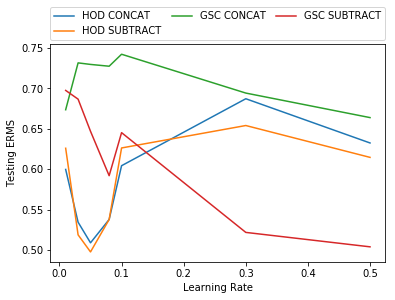

In [33]:
# M = 10
plt.plot([0.01,0.03,0.05,0.08,0.1,0.3, 0.5],[0.59971, 0.53446, 0.50895, 0.53781, 0.60434, 0.68718, 0.63246], label = 'HOD CONCAT')
plt.plot([0.01,0.03,0.05,0.08,0.1,0.3, 0.5],[0.62593, 0.5188, 0.49768, 0.53781, 0.62629, 0.65405, 0.61464], label = 'HOD SUBTRACT')
plt.plot([0.01,0.03,0.05,0.08,0.1,0.3, 0.5],[0.67356, 0.73154, 0.72964, 0.72741, 0.74223, 0.6942, 0.66385], label = 'GSC CONCAT')
plt.plot([0.01,0.03,0.05,0.08,0.1,0.3, 0.5],[0.69749, 0.68668, 0.6469, 0.59199, 0.64523, 0.52182, 0.50397], label = 'GSC SUBTRACT')
plt.ylabel('Testing ERMS')
plt.xlabel('Learning Rate')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
plt.show()

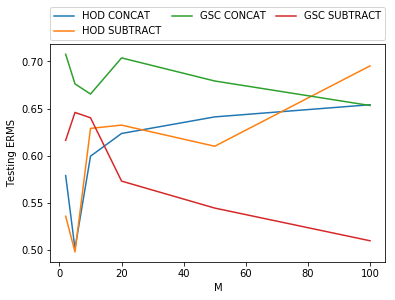

In [37]:
# Learning Rate = 0.1
plt.plot([2,5,10,20,50,100],[0.57899, 0.5017, 0.59955, 0.62361, 0.64118, 0.65405], label = 'HOD CONCAT')
plt.plot([2,5,10,20,50,100],[0.53595, 0.49815, 0.629, 0.63246, 0.6101, 0.69522], label = 'HOD SUBTRACT')
plt.plot([2,5,10,20,50,100],[0.70754, 0.67615, 0.66538, 0.70366, 0.6792, 0.65322], label = 'GSC CONCAT')
plt.plot([2,5,10,20,50,100],[0.61636, 0.6459, 0.64023, 0.57315, 0.54459, 0.50997], label = 'GSC SUBTRACT')
plt.ylabel('Testing ERMS')
plt.xlabel('M')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
plt.show()